# NDA_COURSEWORK Part 2

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from shapely.geometry import box
import random

# Task A: Spatial Networks and Planarity

In [3]:
# Load all accident dataset from files (2010–2019) into one DataFrame
df_2010 = pd.read_csv("../data/part2/2010.csv", encoding="ISO-8859-1")
df_2011 = pd.read_csv("../data/part2/2011.csv", encoding="ISO-8859-1")
df_2012 = pd.read_csv("../data/part2/2012.csv", encoding="ISO-8859-1")
df_2013 = pd.read_csv("../data/part2/2013.csv", encoding="ISO-8859-1")
df_2014 = pd.read_csv("../data/part2/2014.csv", encoding="ISO-8859-1")
df_2015 = pd.read_csv("../data/part2/2015.csv", encoding="ISO-8859-1")
df_2016 = pd.read_csv("../data/part2/Copy%20of%20Leeds_RTC_2016.csv", encoding="ISO-8859-1")
df_2017 = pd.read_csv("../data/part2/Leeds_RTC_2017.csv", encoding="ISO-8859-1")
df_2018 = pd.read_csv("../data/part2/RTC%202018_Leeds.csv", encoding="ISO-8859-1")
df_2019 = pd.read_csv("../data/part2/Traffic%20accidents_2019_Leeds.csv", encoding="ISO-8859-1")


# Combine all years into one DataFrame
df = pd.concat([df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018, df_2019], ignore_index=True)

# Drop records without coordinate datas
df_combined = df.dropna(subset=["Grid Ref: Easting", "Grid Ref: Northing"])

# Convert to GeoDataFrame and reproject to WGS84
accidents_gdf = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined["Grid Ref: Easting"], df_combined["Grid Ref: Northing"]),
    crs="EPSG:27700" # CRS of British National Grid
).to_crs(epsg=4326)

In [5]:
df_combined.head()

,Reference Number,Easting,Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,...,Unnamed: 11,Unnamed: 15,Expr1,1st Road Class & No,Accident Fields_Reference Number,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No
8199,130021591,NaN,NaN,3,15-Jan-13,1545,Unclassified,Dry,Daylight: street lights present,Fine without high winds,...,Driver,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8200,130021629,NaN,NaN,2,15-Jan-13,1640,A,Frost / Ice,Darkness: street lights present and lit,Other,...,Passenger,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8201,130021704,NaN,NaN,2,13-Jan-13,1345,Unclassified,Wet / Damp,Daylight: street lights present,Fine without high winds,...,Driver,Motorcycle over 125cc and up to 500cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8202,130022047,NaN,NaN,1,15-Jan-13,1313,Unclassified,Dry,Daylight: street lights present,Fine without high winds,...,Pedestrian,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8203,130023385,NaN,NaN,1,16-Jan-13,2015,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,...,Passenger,Bus or coach (17 or more passenger seats),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Degree Distribution Comparison: Small Wikidata Editor Network vs Small Random Network

In [6]:

# Defining manual central coordinates in Leeds (Picking coordinates from google maps near to center of leads)
center_lat, center_lon = 53.798928, -1.536309  

# Defining a ~1 km² box around the center (0.0045° ≈ 0.5 km)
buffer = 0.0045
north, south = center_lat + buffer, center_lat - buffer
east, west = center_lon + buffer, center_lon - buffer
selected_box = box(west, south, east, north)

# Counting accidents within the selected box
accidents_in_box = accidents_gdf[accidents_gdf.geometry.within(selected_box)]
print("Number of accidents in 1 km² around selected point:", len(accidents_in_box))


Number of accidents in 1 km² around selected point: 425


## Visualize all accident locations and highlight selected hotspot area

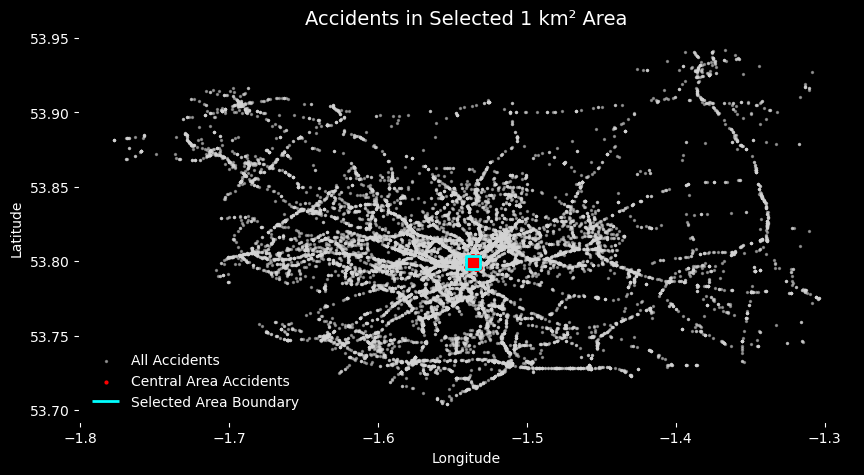

In [7]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')  # large fig, dark mode

# Plot all accidents in light gray
accidents_gdf.plot(
    ax=ax,
    color='lightgray',
    alpha=0.5,
    markersize=2,
    label='All Accidents'
)

# Highlight accidents inside the selected 1 km² box in red
accidents_gdf[accidents_gdf.within(selected_box)].plot(
    ax=ax,
    color='red',
    markersize=4,
    label='Central Area Accidents'
)

# Draw the boundary of the selected 1 km² cell in cyan
gpd.GeoSeries([selected_box]).boundary.plot(
    ax=ax,
    color='cyan',
    linewidth=2,
    label='Selected Area Boundary'
)

# Set title and labels with white text
plt.title("Accidents in Selected 1 km² Area", fontsize=14, color='white')
plt.xlabel("Longitude", color='white')
plt.ylabel("Latitude", color='white')

# Customize ticks and axes for black background
ax.tick_params(colors='white')
ax.set_facecolor('black')

# Add legend
ax.legend(frameon=False, labelcolor='white', fontsize=10)

plt.show()

## Downloading Road Network for selected area from Open Street Map

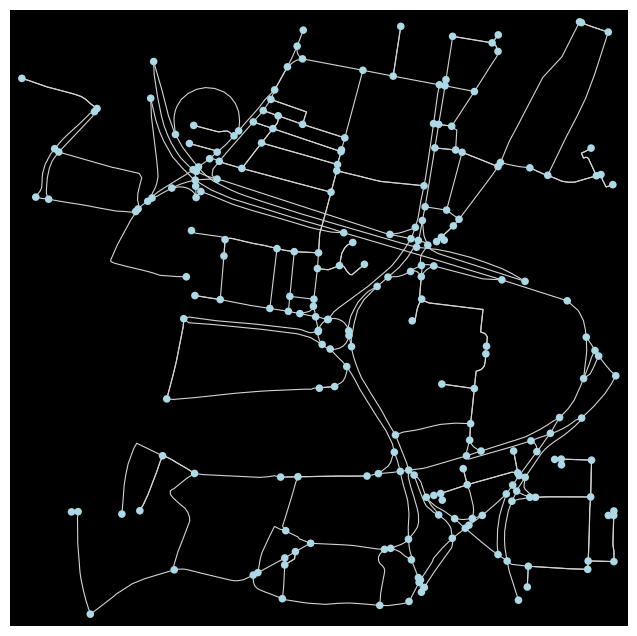

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
# Use graph_from_point to extract ~1 km² network
road_graph = ox.graph.graph_from_point(center_point=(center_lat, center_lon), dist=500, network_type='drive')

# Project to UTM for accurate calculations
road_graph_proj = ox.projection.project_graph(road_graph)

# Plotting the road network with custom styling
ox.plot.plot_graph(
    road_graph_proj,
    bgcolor='black',            # Dark background
    node_size=30,               # Size of intersection points
    node_color="lightblue",     # Color of the nodes
    edge_linewidth=0.8,         # Thickness of road segments
    edge_color="lightgray"      # Color of road segments
)

## Compute road network statistics

In [10]:
# Approximate area of region in m² (1 km²)
area_m2 = 1_000_000

# Compute basic statistics on the projected graph
network_stats = ox.basic_stats(road_graph_proj, area=area_m2)

# Count number of connected components
num_components = nx.number_connected_components(road_graph_proj.to_undirected())

# Get largest connected component for diameter
largest_cc = max(nx.connected_components(road_graph_proj.to_undirected()), key=len)
largest_subgraph = road_graph_proj.subgraph(largest_cc)

# Calculate spatial diameter (in edges)
diameter = nx.diameter(largest_subgraph.to_undirected())

# Extract key metrics
avg_street_length = network_stats["street_length_avg"]
node_density = network_stats["node_density_km"]
edge_density = network_stats["edge_density_km"]
intersection_density = network_stats["intersection_density_km"]
total_edge_length = network_stats["edge_length_total"]

# Circuitry = total edge length / sum of distances to centroid
nodes_proj = ox.graph_to_gdfs(road_graph_proj, nodes=True, edges=False)
centroid = nodes_proj.unary_union.centroid
euclid_dists = [centroid.distance(pt) for pt in nodes_proj.geometry]
euclid_total = np.sum(euclid_dists)
circuitry = total_edge_length / euclid_total if euclid_total > 0 else None

# Check if the network is planar
is_planar, counterexample = nx.check_planarity(road_graph_proj.to_undirected(),counterexample=True)

/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/2612401908.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = nodes_proj.unary_union.centroid


## Displaying results

In [11]:
print("\n--- Road Network Metrics ---")
print(f"Num of Connected Components: {num_components}")
print(f"Spatial Diameter: {diameter}")
print(f"Average Street Length: {avg_street_length:.2f} meters")
print(f"Node Density: {node_density:.2f} nodes/km²")
print(f"Edge Density: {edge_density:.2f} edges/km²")
print(f"Intersection Density: {intersection_density:.2f} intersections/km²")
print(f"Average Circuitry: {circuitry:.2f}")
print(f"Is the Network Planar? {'Yes' if is_planar else 'No'}")


--- Road Network Metrics ---
Num of Connected Components: 1
Spatial Diameter: 27
Average Street Length: 62.20 meters
Node Density: 231.00 nodes/km²
Edge Density: 23890.38 edges/km²
Intersection Density: 204.00 intersections/km²
Average Circuitry: 0.30
Is the Network Planar? No


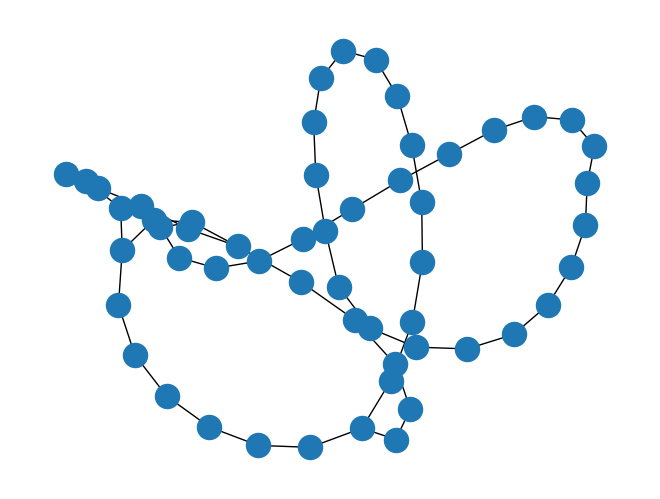

In [13]:
nx.draw(counterexample)

# Task B: Road Accidents

# Task C: Voronoi Diagrams

# Task D: TransE, PROV, PageRank